In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import dslabs_functions as dslab


In [15]:
df = pd.read_csv("../../../data/class_credit_score.csv", index_col="ID")

In [16]:
def handle_outliers(data: pd.DataFrame):
    data = data.copy(deep=True)
    numeric_vars = dslab.get_variable_types(data)["numeric"]
    summary = data[numeric_vars].describe()
    for var in numeric_vars:
        top, bottom = dslab.determine_outlier_thresholds_for_var(summary[var], std_based=False)

        data[var + "_drop"] = data[var]
        data[var + "_drop"] = data[var].apply(
            lambda x: np.NaN if x > top or x < bottom else x
        )

        median = data[var].median()
        data[var + "_median"] = data[var].apply(
            lambda x: median if x > top or x < bottom else x
        )

        data[var + "_truncated"] = data[var].apply(
            lambda x: top if x > top else bottom if x < bottom else x
        )
    return data


0it [00:00, ?it/s]

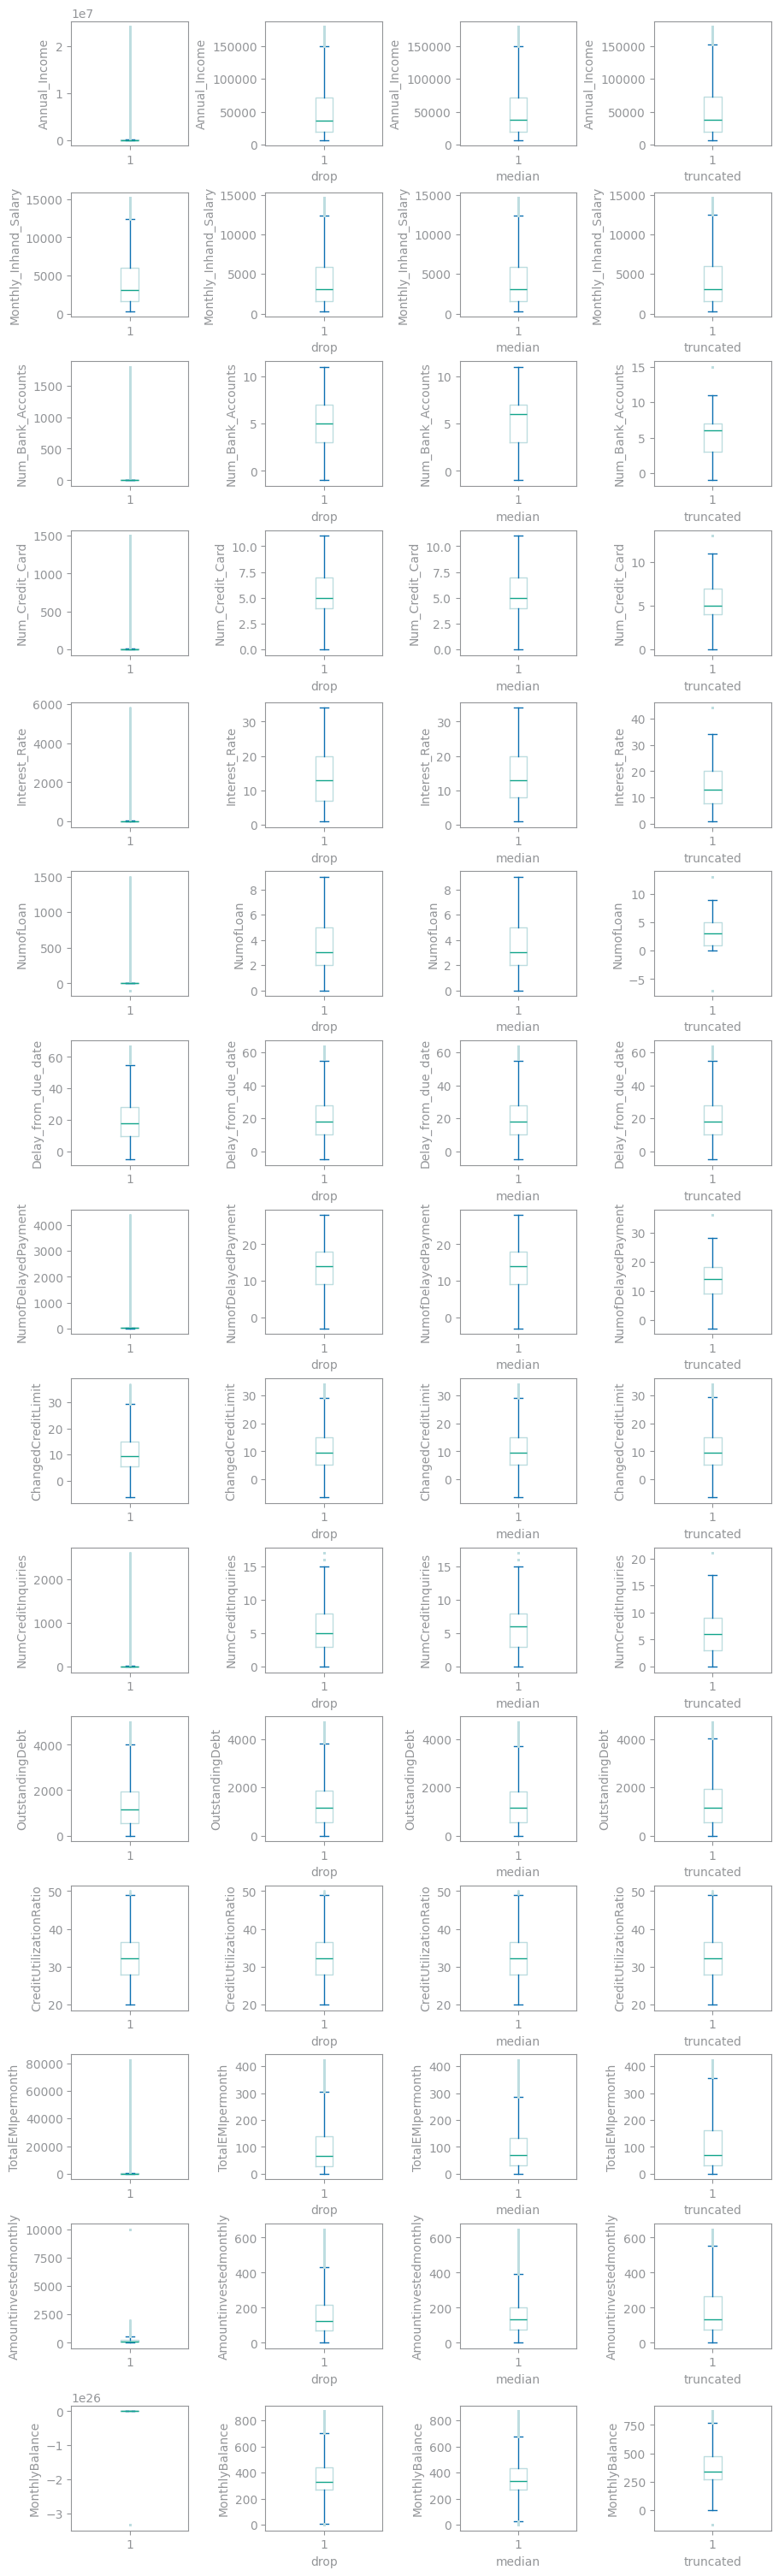

In [17]:
flierprops = dict(markersize=1)
numeric_vars = dslab.get_variable_types(df)["numeric"]
df_with_outliers = handle_outliers(df)
fig, axs = plt.subplots(ncols=4, nrows=len(numeric_vars), figsize=(9, 2 * len(numeric_vars)), constrained_layout=True)
for i, var in tqdm(enumerate(numeric_vars)):
    var_data = df_with_outliers[var]
    var_data = var_data[~np.isnan(var_data)]
    axs[i, 0].boxplot(var_data, flierprops=flierprops)
    axs[i, 0].set_ylabel(var)
    for j, approach in enumerate(["drop", "median", "truncated"]):
        var_data = df_with_outliers[var + "_" + approach]
        var_data = var_data[~np.isnan(var_data)]
        axs[i, j + 1].boxplot(var_data, flierprops=flierprops)
        axs[i, j + 1].set_ylabel(var)
        axs[i, j + 1].set_xlabel(f"{approach}")

plt.savefig(f"images/service_outlier_removal.png", bbox_inches='tight')

In [18]:
def remove_outliers(data: pd.DataFrame, strategy: str, std_based=False) -> pd.DataFrame:
    data = data.copy(deep=True)
    numeric_vars = dslab.get_variable_types(data)["numeric"]
    summary = data[numeric_vars].describe()
    for var in numeric_vars:
        top, bottom = dslab.determine_outlier_thresholds_for_var(summary[var], std_based=std_based)

        if strategy == "drop":
            data[var] = data[var].apply(
                lambda x: np.NaN if x > top or x < bottom else x
            )
            data.dropna(subset=[var])
        elif strategy == "median":
            median = data[var].median()
            data[var] = data[var].apply(
                lambda x: median if x > top or x < bottom else x
            )
        elif strategy == "truncate":
            data[var] = data[var].apply(
                lambda x: top if x > top else bottom if x < bottom else x
            )
        else:
            raise ValueError(f"{strategy} not available")
    return data

df_removed = remove_outliers(df, strategy="drop")
df_removed.to_csv("../../../data/class_credit_score_outliers_removed.csv")


In [19]:
df_removed

,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,...,CreditMix,OutstandingDebt,CreditUtilizationRatio,Credit_History_Age,Payment_of_Min_Amount,TotalEMIpermonth,Amountinvestedmonthly,Payment_Behaviour,MonthlyBalance,Credit_Score
ID,,,,,,,,,,,,,,,,,,,,,
0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3.0,4.0,...,NaN,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.415295,High_spent_Small_value_payments,312.494089,Good
0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3.0,4.0,...,Good,809.98,31.944960,NaN,No,49.574949,118.280222,Low_spent_Large_value_payments,284.629163,Good
0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3.0,4.0,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521,Low_spent_Medium_value_payments,331.209863,Good
0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3.0,4.0,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.458074,Low_spent_Small_value_payments,223.451310,Good
0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3.0,4.0,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153,High_spent_Medium_value_payments,341.489231,Good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0x25fe9,CUS_0x942c,April,Nicks,25,078-73-5990,Mechanic,39628.99,3359.415833,4.0,6.0,...,NaN,502.38,34.663572,31 Years and 6 Months,No,35.104023,60.971333,High_spent_Large_value_payments,479.866228,Poor
0x25fea,CUS_0x942c,May,Nicks,25,078-73-5990,Mechanic,39628.99,3359.415833,4.0,6.0,...,NaN,502.38,40.565631,31 Years and 7 Months,No,35.104023,54.185950,High_spent_Medium_value_payments,496.651610,Poor
0x25feb,CUS_0x942c,June,Nicks,25,078-73-5990,Mechanic,39628.99,3359.415833,4.0,6.0,...,Good,502.38,41.255522,31 Years and 8 Months,No,35.104023,24.028477,High_spent_Large_value_payments,516.809083,Poor
